  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  
Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')
Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64
Linear Re

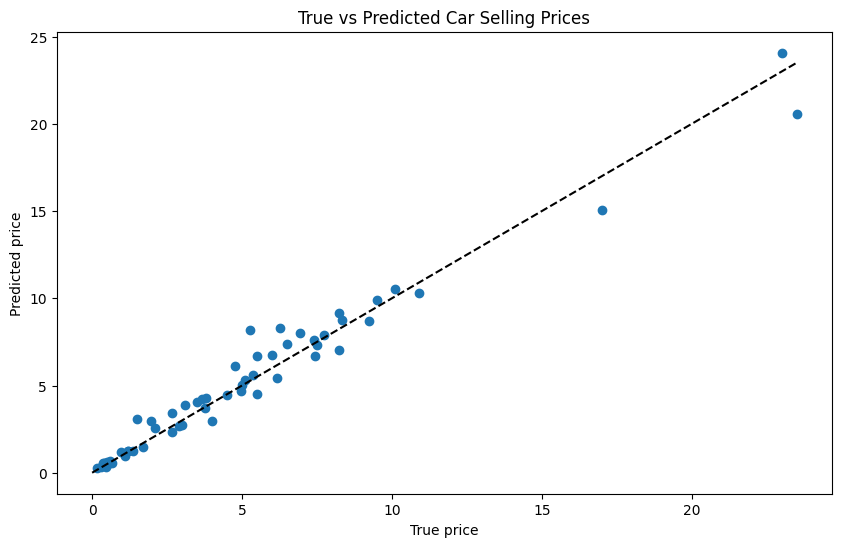

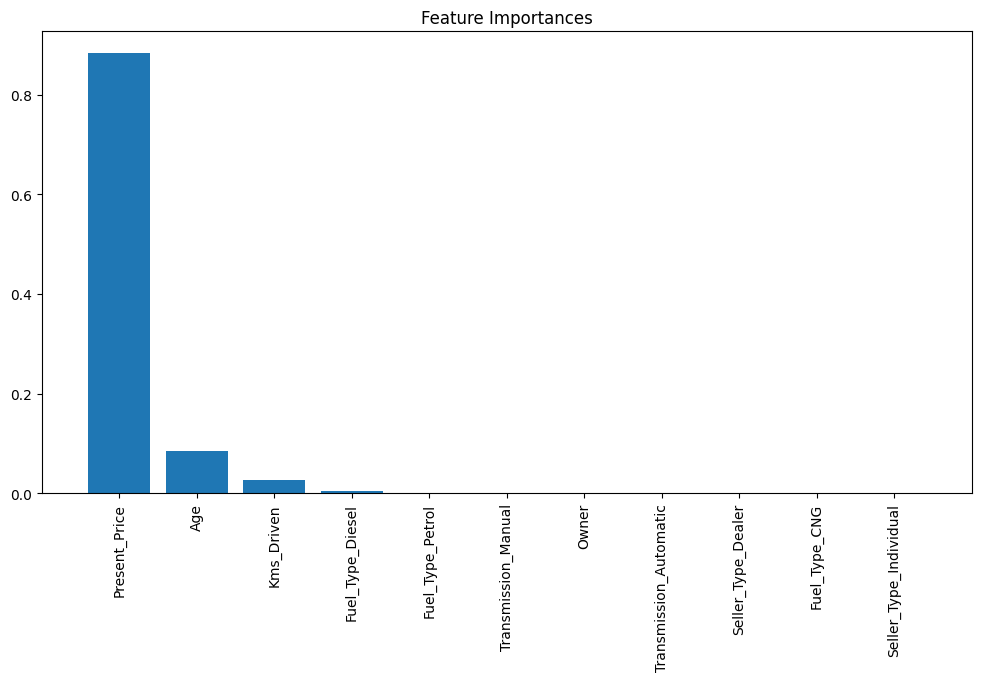

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('car.csv')  # Replace with your dataset file name

# Display the first few rows of the dataset
print(data.head())

# Display the column names and missing values
print(data.columns)
print(data.isnull().sum())

# Convert year to age of the car
data['Age'] = 2024 - data['Year']  # Assuming the current year is 2024
data.drop(['Year', 'Car_Name'], axis=1, inplace=True)

# Preprocess the data
# Define categorical and numerical columns
categorical_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
numerical_features = ['Age', 'Present_Price', 'Kms_Driven', 'Owner']

# Define the preprocessor
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into features and target variable
X = data.drop('Selling_Price', axis=1)
y = data['Selling_Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    "Linear Regression": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]),
    "Gradient Boosting": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])
}

# Train the models and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# Select the best model (example with Gradient Boosting)
best_model = models["Gradient Boosting"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], '--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.title('True vs Predicted Car Selling Prices')
plt.show()

# Display feature importances (only for tree-based models)
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importances = best_model.named_steps['regressor'].feature_importances_
    indices = np.argsort(importances)[::-1]

    # Get feature names after one-hot encoding
    ohe_features = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = np.concatenate((numerical_features, ohe_features))

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), all_features[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()
